# Tutorial 3.1. Creating "Binless" Schemes: Na<sup>+</sup>/Cl<sup>-</sup> Association Simulations
Author: Jeremy Leung<br>
Email:&nbsp;&nbsp; jml230@pitt.edu

## Introduction

This document is a companion jupyter notebook for first tutorial in the WESTPA 2.0 Suite of Tutorials. It involves running a Na<sup>+</sup>/Cl<sup>-</sup> association simulation using WESTPA's new binless resampler module and other advanced analysis suites. Upon completion of this tutorial, a user should be able to initiate WE simulations from multiple basis states and customize their own binless scheme. This tutorial builds upon the basics explained in the Na<sup>+</sup>/Cl<sup>-</sup> tutorial of the original suite of tutorials on LiveCoMS ([Bogetti et al., 2019](https://www.livecomsjournal.org/index.php/livecoms/article/view/v1i2e10607)) and readers are advised to refer to that document as necessary. 

## Learning Objectives
- Learn to customize WESTPA's new binless resampler module.
- Run a WE simulation using the "group by history" scheme.
- How to use multiple basis states in a WE simulation and visualize its coverage.
- Concatinate multiple west.h5 files using <code>w_multi_west</code>.

## System Requirements
- OpenMM and MDTraj are necessary to run this simulation.
    - Note that MDTraj is a dependency of WESTPA 2.0.
- numpy, matplotlib, ipympyl, mdtraj, and nglview are used in this jupyter notebook. 
    - nglview, matplotlib, ipympl, and numpy are optional for visualization purposes.

## Running the Simulation

The files to initialize and run the WESTPA simulation are included with this jupyter notebook as a demo/example. **It is not recommended that you run your WE simulations within a Jupyter Notebook.** The simulation will take a while so feel free to stop it at the run stage. Sample completed files for analysis are provided in the for_analysis/ directory.

In [ ]:
import os
import shutil
# Clean up from previous/ failed simulations.
for i in ['west.h5', 'seg_logs', 'traj_segs','istates']:
    try:
        os.remove(i)
    except OSError:
        try:
            shutil.rmtree(i)
        except OSError:
            pass
        
for i in ['seg_logs','traj_segs','istates']:
    os.mkdir(i)

In [ ]:
import westpa
import numpy
from westpa.cli.core import w_init

# Initializing the System:
class Params:
    def __init__(self):
        pass


if __name__ == "__main__":

    # Set some parameters that WESTPA needs to set simulation state.
    args = Params()
    args.rcfile = 'west.cfg'
    args.verbosity = "verbose" ## change to debug if you want a more detailed view of what's happening. 

    # Update westpa.rc with these
    westpa.rc.process_args(args)

    # Initialize the simulation using the tstate and bstate files
    w_init.initialize(tstates=None, bstates=None,
                      tstate_file='tstate.file', bstate_file='bstates/bstates.txt',
                      segs_per_state=5, shotgun=False)

In [ ]:
import westpa
import numpy
from westpa.cli.core import w_run
import westpa.work_managers as work_managers

# Running the Simulation.
class Params:
    def __init__(self):
        pass


if __name__ == "__main__":

    # Set some parameters that WESTPA needs to set simulation state.
    args = Params()
    args.rcfile = 'west.cfg'
    args.verbosity = "verbose"
    args.work_manager = 'threads'

    # Update westpa.rc with these
    westpa.rc.process_args(args)

    # Prepare work manager
    work_managers.environment.process_wm_args(args)

    # Launch the simulation
    w_run.run_simulation()

## Monitoring and Analyzing the WE Simulation

### Visualization of the System

We will now take a look at how one of the basis states looks like. The water box is omitted for visibility. Na<sup>+</sup> is red and Cl<sup>-</sup> is blue in the representation.

In [6]:
import mdtraj
import nglview
system = mdtraj.load('bstates/01/basis.xml', top='common_files/bstate.pdb')
Na = list(range(0,1)) # Na+ is the first atom
Cl = list(range(1,2)) # Cl- is the second atom
both = Na + Cl # Na+ + Cl-
system = system.atom_slice(both)
view = nglview.show_mdtraj(system)
view.representations = [
    {"type": "ball+stick", "params": {
        "sele": ".Na+", "color": "red"
    }},
    {"type": "ball+stick", "params": {
        "sele": ".Cl-", "color": "blue"
    }}
]
view.background = 'white'
view

NGLWidget()

### Visualization of Coverage of the Basis States

The following cells plots the multiple basis states in a way that allows us to examine  their spacial coverage. The first cell visualizes the system one-by-one after alignment to Na<sup>+</sup>. The second cell plots all the center-of-masses at once.

Do note that many lines are not necessary for Na<sup>+</sup>/Cl</sup>-</sup> as it is spherically symmetrical, and that its center of mass is equal to its coordinate. Extra code is provided so it could be generalized to larger systems.

In [130]:
import numpy
import mdtraj
import nglview
lst = numpy.loadtxt('bstates/bstates.txt', usecols=2, dtype=str) # Reading basis state names
tpg = 'common_files/bstate.pdb' # Topology File for basis state (Shared between all bstates)
lst = [x + "/basis.xml" for x in lst] # Change path to point to file name

# Reading reference and setup
# There might be some warnings about unconverged rotation matrices because of the system's rotational symmetry

com = [] # list containing all CoM
a = mdtraj.load('bstates/01/basis.xml', top=tpg) # Load the first
a_slice = a.atom_slice([0,1]) # Just Na+
com.append(numpy.squeeze(mdtraj.compute_center_of_mass(a_slice))) # Save CoM of Na+
a_slice = a.atom_slice([0,1]) # Both Na+/Cl-

# Loading and superposing, storing Center of Mass (CoM) to list for heatmap
c = a_slice
for i in lst:
    b = mdtraj.load('bstates/' + i, top=tpg)
    b = b.atom_slice([0,1])
    b.superpose(a_slice, atom_indices=[0])
    c = mdtraj.join([c,b], check_topology=False)
    # Just saving the CoM of Cl-, since Na+ is superimposed
    com.append(numpy.squeeze(mdtraj.compute_center_of_mass(b.atom_slice([1]))))
com = numpy.asarray(com)

# Now displaying it, note that Cl- is not visible in some frames unless you rotate the camera
view2 = nglview.show_mdtraj(c)
view2.representations = [
    {"type": "ball+stick", "params": {
        "sele": ".Na+", "color": "red"
    }},
    {"type": "ball+stick", "params": {
        "sele": ".Cl-", "color": "blue"
    }}
]
view2.center('.Na+')
view2.control.zoom(-1.75)
view2

mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296


NGLWidget(max_frame=10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
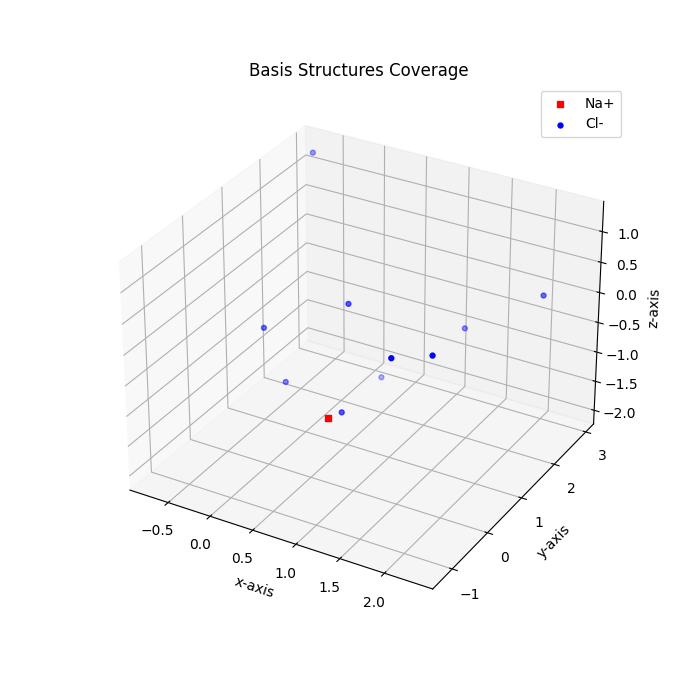

In [131]:
# Looking at the coverage of the bstates, assuming you ran the previous 2 cells
# Comment out the following line or install ipypml if you have trouble viewing.
%matplotlib widget 
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
import numpy

fig = matplotlib.pyplot.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

img1 = ax.scatter(com[0,0], com[0,1], com[0,2], s=20, marker='s', color='Red', label='Na+')
img2 = ax.scatter(com[1:,0], com[1:,1], com[1:,2], s=50, marker='.', color='Blue', label='Cl-')

# Labels and Titles
ax.set_title("Basis Structures Coverage")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.legend()

show()

Due to the rotational symmetry, it might be worth looking atthe Na<sup>+</sup>/Cl<sup>-</sup> atom-to-atom distances, which are already precalculated in each pcoord.init file.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
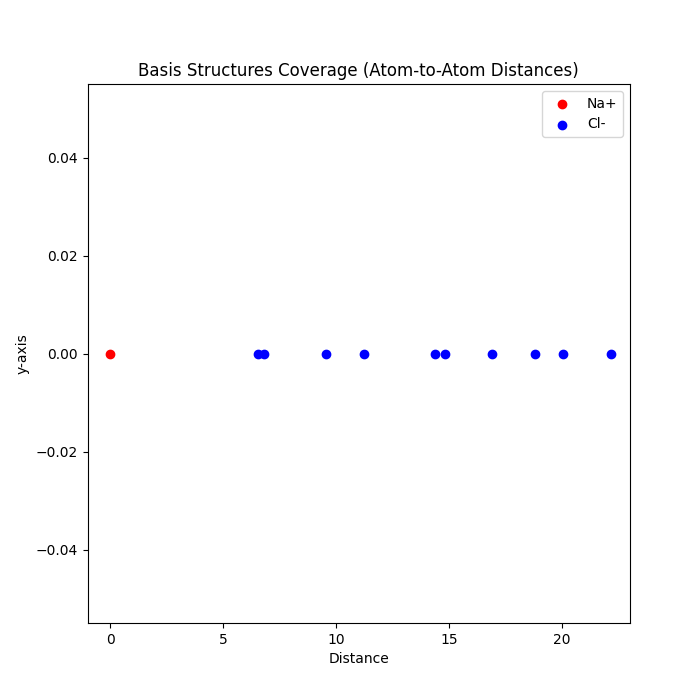

In [132]:
import numpy
lst = numpy.loadtxt('bstates/bstates.txt', usecols=2, dtype=str) # Reading basis state names
lst2 = ["bstates/" + x + "/pcoord.init" for x in lst] # Change path to point to file name

values = numpy.asarray([numpy.loadtxt(x) for x in lst2])

fig2 = matplotlib.pyplot.figure(figsize=(7,7))
ax2 = fig2.subplots()

img3 = ax2.scatter(0, 0, color='Red', label='Na+')
img4 = ax2.scatter(values[:], numpy.zeros(value.shape[0]), color='Blue', label='Cl-')

# Labels and Titles
ax2.set_title("Basis Structures Coverage (Atom-to-Atom Distances)")
ax2.set_xlabel('Distance')
ax2.set_ylabel('y-axis')
ax2.legend()
plt.xlim(-1,23)

show()


## Combining Multiple Simulation Runs

The following sample code runs <code>w_multi_west</code> to concatenate two runs.

In [24]:
import tarfile

# Untar the files
for file in ['./for_analysis/nacl.hdf5.h5.1.tar.gz','./for_analysis/nacl.hdf5.h5.2.tar.gz']:
    with tarfile.open(file) as tar_f:
        tar_f.extractall('./for_analysis')

Operation:      Initializing

Operation:      Initializing
Traceback (most recent call last):
  File "/home/jml230/anaconda3/envs/westpa2-openmm/bin/w_multi_west", line 33, in <module>
    sys.exit(load_entry_point('westpa', 'console_scripts', 'w_multi_west')())
  File "/home/jml230/git/westpa/src/westpa/cli/tools/w_multi_west.py", line 357, in entry_point
    WMultiWest().main()
  File "/home/jml230/git/westpa/src/westpa/tools/core.py", line 248, in main
    self.go()
  File "/home/jml230/git/westpa/src/westpa/cli/tools/w_multi_west.py", line 195, in go
    bin_mapper = get_bin_mapper(west, bytes(binhash, 'utf-8'))
  File "/home/jml230/git/westpa/src/westpa/cli/tools/w_multi_west.py", line 86, in get_bin_mapper
    mapper = pickle.loads(pkldat)
ValueError: unsupported pickle protocol: 5


In [123]:
# Run w_multi_west in the commandline
!{'w_multi_west -m ./for_analysis/ -n 2'}
print('Done!')

Operation:      Initializing

None
Operation:      Recreating...
Progress:       0%   [                                                         ]
Time remaining: unknown
Operation:      Recreating...
Progress:       20%  [===========                                              ]
Time remaining: less than 1 minute
Operation:      Recreating...
Progress:       40%  [=======================                                  ]
Time remaining: less than 1 minute
Operation:      Recreating...
Progress:       58%  [=================================                        ]
Time remaining: less than 1 minute
Operation:      Recreating...
Progress:       79%  [=============================================            ]
Time remaining: less than 1 minute
Operation:      Recreating...
Progress:       99%  [======================================================== ]
Time remaining: less than 1 minute

Operation:      Recreating...

Progress:       100% [==============================================

In [129]:
# Check to see if the multi.h5 file exists
from os.path import exists
exists('multi.h5')

True